In [1]:
# Install needed stuff to the Jupyter and kernel environment

%pip install pyarrow
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install pyfinance
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import needed stuff
import pyarrow.feather as feather
import math
import pandas
import numpy as np
import matplotlib.pyplot as plt
from pyfinance.options import BSM
import yfinance as yf
from datetime import datetime, timedelta

In [3]:
# General Delta-hedging function
def number_of_shares_to_buy(shares_per_contract, number_of_options, delta_of_option):
    delta_of_underlying = 1 # why?

    # Delta-hedging says:
    # number_of_shares * delta_of_underlying + number_of_options * delta_of_option = 0
    number_of_shares = (-number_of_options * delta_of_option / delta_of_underlying ) * shares_per_contract

    print("To delta-hedge the portoflio, you need to",("buy" if number_of_shares >= 0 else "sell"), round(np.abs(number_of_shares),2), "shares.")
    return number_of_shares


In [4]:
# General volatility function
def get_volatility(stock_data):
    log_returns = np.log(stock_data/stock_data.shift(1)).dropna()
    volatility = log_returns.rolling(window = 21).std() * np.sqrt(252)
    return volatility

In [5]:
# General plot function
def plot_stock_price_and_volatility(stock_prices, volatility):
    fig, ax = plt.subplots()
    ax.plot(stock_prices, color='red')
    ax.set_xlabel('Date', fontsize = 14)
    ax.set_ylabel('Underlying price', color='red', fontsize = 14)
    
    ax2 = ax.twinx()
    ax2.plot(volatility, color = 'blue')
    ax2.set_ylabel('Volatility', color = 'blue', fontsize = 14)
    
    plt.show()

## Let's use Apple stock data from Refinitiv here

/tmp/ipykernel_19398/3422054255.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  call_delta = BSM(kind='call', S0=date_as_index['Underlying'][-1], K=date_as_index['Underlying'][-1], T=0.25, r=0.05, sigma=vola[-1]).delta()
/tmp/ipykernel_19398/3422054255.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  put_delta = BSM(kind='put', S0=date_as_index['Underlying'][-1], K=date_as_index['Underlying'][-1], T=0.25, r=0.05, sigma=vola[-1]).delta()


Delta of the call option: 0.56291693680677
Delta of the put option: -0.43708306319323
To delta-hedge the portoflio, you need to sell 56.29 shares.
You have to sell -56.291693680677 stocks to delta-hedge the portfolio
To delta-hedge the portoflio, you need to buy 43.71 shares.
You have to buy 43.708306319323 stocks to delta-hedge the portfolio


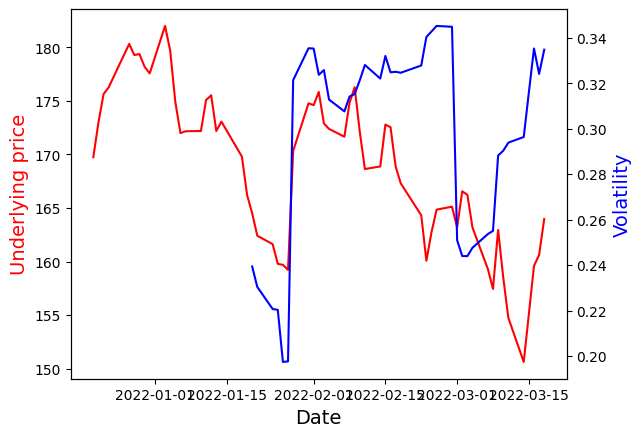

In [6]:
# Read data and show it, data is from Refinitiv workspace
apple_stock_data_as_df = feather.read_feather('../data/fe2.feather')

# Set date to index instead of running index from 1..n
date_as_index = apple_stock_data_as_df.set_index('Date', inplace=False)

vola = get_volatility(date_as_index['Underlying'])

# Set values
shares_per_contract = 100 # How this is determined ?

number_of_options = 1 # How this is determined? 1 stock = 1 option, n stocks = n options?

# Use Black-Scholes model to compute the delta of the call option
# T = maturity and r = interest rate just thrown there, no spesific reason I guess to be those
call_delta = BSM(kind='call', S0=date_as_index['Underlying'][-1], K=date_as_index['Underlying'][-1], T=0.25, r=0.05, sigma=vola[-1]).delta()

# Delta of the call option is always positive and between 0 and 1
print("Delta of the call option:", call_delta)

# Use Black-Scholes model to compute the delta of the put option
# Again T = maturity and r = interest rate are just thrown there, no spesific reason to be those (I think)
put_delta = BSM(kind='put', S0=date_as_index['Underlying'][-1], K=date_as_index['Underlying'][-1], T=0.25, r=0.05, sigma=vola[-1]).delta()

# Delta of the put option is always negative and between 0 and -1
print("Delta of the put option:", put_delta)

# Get the amounts to balance, aka delta-hedge the portfolio
how_many_shares_to_sell = number_of_shares_to_buy(shares_per_contract, number_of_options, call_delta)
print("You have to sell " + str(how_many_shares_to_sell) + " stocks to delta-hedge the portfolio")

how_many_shares_to_buy = number_of_shares_to_buy(shares_per_contract, number_of_options, put_delta)
print("You have to buy " + str(how_many_shares_to_buy) + " stocks to delta-hedge the portfolio")

plot_stock_price_and_volatility(date_as_index['Underlying'], vola)

# Lets try with S&P 500 data

[*********************100%%**********************]  1 of 1 completed


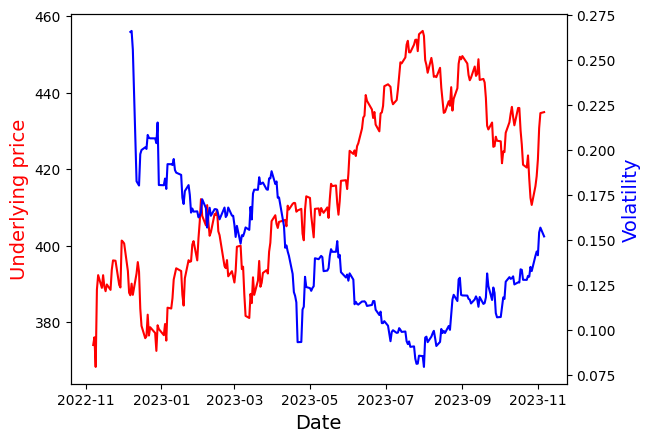

In [7]:
stock_name = 'SPY'
years = 1
stock_data = yf.download(tickers = stock_name, start = datetime.today() - timedelta(days=years*365), end = datetime.today())

stock_data # Date as index, Open, High, Low, Close, Adj Close, Volume

stock_prices = stock_data['Adj Close'] # Closing prices
spy_vola = get_volatility(stock_prices)
plot_stock_price_and_volatility(stock_prices, spy_vola)